# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])

import re
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.utils import resample
import sqlite3
from sqlalchemy import create_engine
import pickle
from sklearn.externals import joblib
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
# load data from database
engine = create_engine('sqlite:///DisasterMessages.db')
df = pd.read_sql_table('DisasterMessages', engine)
target_names = ['related', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']
X = df['message']
Y = df[target_names]

In [3]:
# Show 20 example messages
pd.options.display.max_colwidth = 110
for i in range(20):
    print(X.iloc[i])
    print('')

Weather update - a cold front from Cuba that could pass over Haiti

Is the Hurricane over or is it not over

Looking for someone but no name

UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.

says: west side of Haiti, rest of the country today and tonight

Information about the National Palace-

Storm at sacred heart of jesus

Please, we need tents and water. We are in Silo, Thank you!

I would like to receive the messages, thank you

I am in Croix-des-Bouquets. We have health issues. They ( workers ) are in Santo 15. ( an area in Croix-des-Bouquets )

There's nothing to eat and water, we starving and thirsty.

I am in Petionville. I need more information regarding 4636

I am in Thomassin number 32, in the area named Pyron. I would like to have some water. Thank God we are fine, but we desperately need water. Thanks

Let's do it together, need food in Delma 75, in didine area

More information on the 4636 number in order for me to par

### 2. Write a tokenization function to process your text data

In [4]:
def tokenize(text):
    # Remove punctuation characters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text) 
    # Tokenise
    tokens = word_tokenize(text)
    # Create lemmatiser
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    # Lemmatize, standardise (lower case) & clean tokens
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [5]:
# Define ML pipeline
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(SVC()))
    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [6]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=49)

# Train pipeline
pipeline.fit(X_train, y_train)

# predict on test data
y_pred = pipeline.predict(X_test)

# Re-structure returned numpy array as dataframe with same column names
y_pred = pd.DataFrame(y_pred)
y_pred.columns = target_names

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [7]:
def performance_report(actual, predicted, target_names):
    
    metrics = []
    
    # For each of the target features
    for i in target_names:
        # Calculate metrics
        accuracy = accuracy_score(actual[i], predicted[i])
        precision = precision_score(actual[i], predicted[i])
        recall = recall_score(actual[i], predicted[i])
        f1 = f1_score(actual[i], predicted[i])
        # Save metrics
        metrics.append([accuracy, precision, recall, f1])
    
    # Convert to numpy array
    metrics = np.array(metrics)
    # Convert to dataframe
    metrics_df = pd.DataFrame(data = metrics, index = target_names, columns = ['Accuracy', 'Precision', 'Recall', 'F1'])
    # Add mean
    mean_acc = metrics_df['Accuracy'].mean()
    mean_pre = metrics_df['Precision'].mean()
    mean_rec = metrics_df['Recall'].mean()
    mean_f1 = metrics_df['F1'].mean()
    row = pd.Series({'Accuracy':mean_acc,'Precision':mean_pre,'Recall':mean_rec,'F1':mean_f1},name='MEAN SCORE')
    metrics_df = metrics_df.append(row)
    return metrics_df

In [8]:
# Show metrics for each category
print(performance_report(y_test, y_pred, target_names))

                        Accuracy  Precision    Recall        F1
related                 0.763656   0.763656  1.000000  0.865992
request                 0.832926   0.000000  0.000000  0.000000
offer                   0.996338   0.000000  0.000000  0.000000
aid_related             0.587428   0.000000  0.000000  0.000000
medical_help            0.922490   0.000000  0.000000  0.000000
medical_products        0.951938   0.000000  0.000000  0.000000
search_and_rescue       0.973299   0.000000  0.000000  0.000000
security                0.983369   0.000000  0.000000  0.000000
military                0.967043   0.000000  0.000000  0.000000
water                   0.937748   0.000000  0.000000  0.000000
food                    0.891517   0.000000  0.000000  0.000000
shelter                 0.911504   0.000000  0.000000  0.000000
clothing                0.987946   0.000000  0.000000  0.000000
money                   0.977113   0.000000  0.000000  0.000000
missing_people          0.989472   0.000

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


So we can see the metric values vary considerably, this is probably due to the low number of examples for particular categories (as we can see from the warnings, some have no examples to test). In particular while accuracy is high, recall, precison and f1 scores are zero with this model.

### 6. Improve your model
Use grid search to find better parameters. 

In [9]:
#parameters = {
        #'vect__ngram_range': ((1, 2)),
        #'vect__max_df': (0.5, 0.75, 1.0),
        #'vect__max_features': (None, 5000, 10000),
        #'tfidf__use_idf': (True, False),
        #'clf__estimator__n_estimators':[15, 50], 
        #'clf__estimator__min_samples_split':[2, 5, 10]
        #'vect__max_df': (0.5, 0.75),
#}

#cv = GridSearchCV(pipeline, param_grid=parameters)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [10]:
# Train pipeline with grid search
#cv.fit(X_train, y_train)

# predict on test data
#y_pred2 = cv.predict(X_test)

# Re-structure returned numpy array as dataframe with same column names
#y_pred2 = pd.DataFrame(y_pred2)
#y_pred2.columns = target_names

# Evaluate the model
#evaluate_model(y_test, y_pred2, target_names)

### 8. Try improving your model further. Here are a few ideas:

Reading on various techniques in several articles including these:

https://towardsdatascience.com/machine-learning-multiclass-classification-with-imbalanced-data-set-29f6a177c1a

https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

I decided to try 3 approaches to try to improve results.

- Oversampling minority categories in the data
- Change model to Gradient Boosting 
- Add starting verb feature

#### 8.1 Change model to Gradient Boost

In [11]:
# Define ML pipeline
pipeline2 = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(GradientBoostingClassifier(random_state=1)))
    ])

# Train pipeline
pipeline2.fit(X_train, y_train)

# predict on test data
y_pred2 = pipeline2.predict(X_test)

# Re-structure returned numpy array as dataframe with same column names
y_pred2 = pd.DataFrame(y_pred2)
y_pred2.columns = target_names

# Evaluate the model
print(performance_report(y_test, y_pred2, target_names))

                        Accuracy  Precision    Recall        F1
related                 0.795392   0.801812  0.972428  0.878916
request                 0.903570   0.838946  0.523288  0.644544
offer                   0.992218   0.000000  0.000000  0.000000
aid_related             0.758773   0.804997  0.548077  0.652145
medical_help            0.928746   0.625767  0.200787  0.304024
medical_products        0.961245   0.704698  0.333333  0.452586
search_and_rescue       0.970095   0.387097  0.205714  0.268657
security                0.975435   0.080645  0.045872  0.058480
military                0.968874   0.571429  0.222222  0.320000
water                   0.963381   0.738636  0.637255  0.684211
food                    0.955294   0.800287  0.783404  0.791756
shelter                 0.947971   0.799499  0.550000  0.651685
clothing                0.987641   0.489130  0.569620  0.526316
money                   0.975282   0.409091  0.180000  0.250000
missing_people          0.985352   0.245

#### 8.2 Oversampling minority categories in the data

We saw in the ETL phase how there was a high degree of variance on examples for each of the classes, with some classes/categories having few as 120 examples and others as high as 20,000 examples - so this is a very unbalanced dataset. Two common methods used to address this are oversampling and undersampling. Given our total dataset is around 26,000 rows, I will look at the oversampling technique to generate more samples from the minority category.

In [12]:
# Get the sum of all occurances of all categories
categories_total = y_train.sum(axis = 0)
categories_total_df = pd.DataFrame(categories_total)
categories_total_df = categories_total_df.sort_values(by=[0])
# List the 10 lowest categories and their total occurances
categories_total_df.head(10)

,0
shops,80
offer,94
tools,133
hospitals,216
fire,219
missing_people,229
aid_centers,233
clothing,326
security,362
cold,382


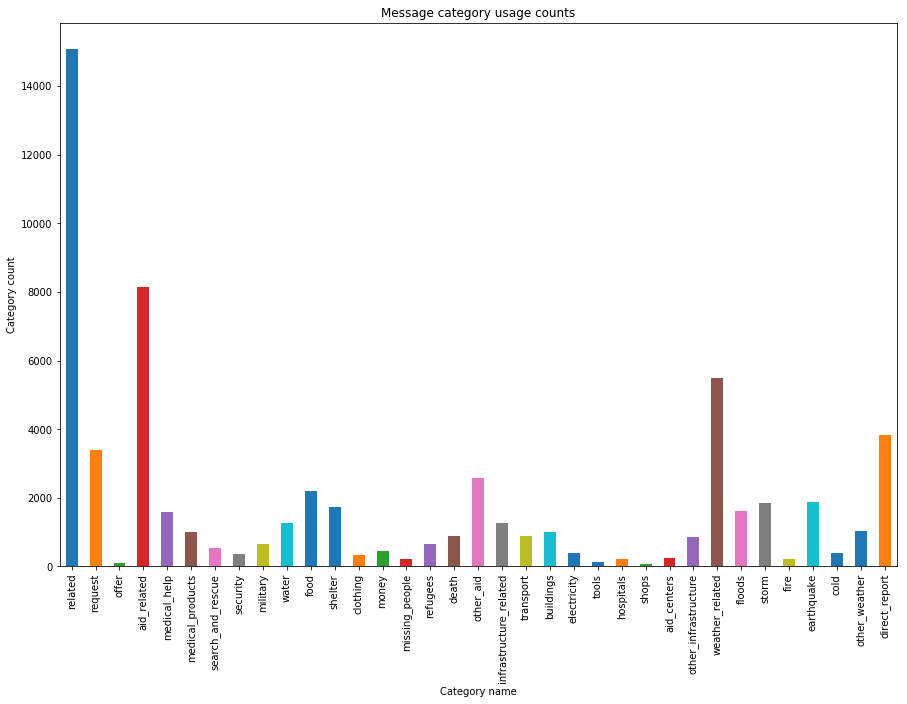

In [13]:
# Create function to show count totals of categories as a bar chart
def plot_target_feature_counts(features_df):
    """"""
    features_totals = features_df.apply(pd.Series.value_counts)
    ax = features_totals.iloc[1].plot.bar(figsize=(15,10))
    ax.set_xlabel("Category name")
    ax.set_ylabel("Category count")
    ax.set_title("Message category usage counts")

plot_target_feature_counts(y_train)

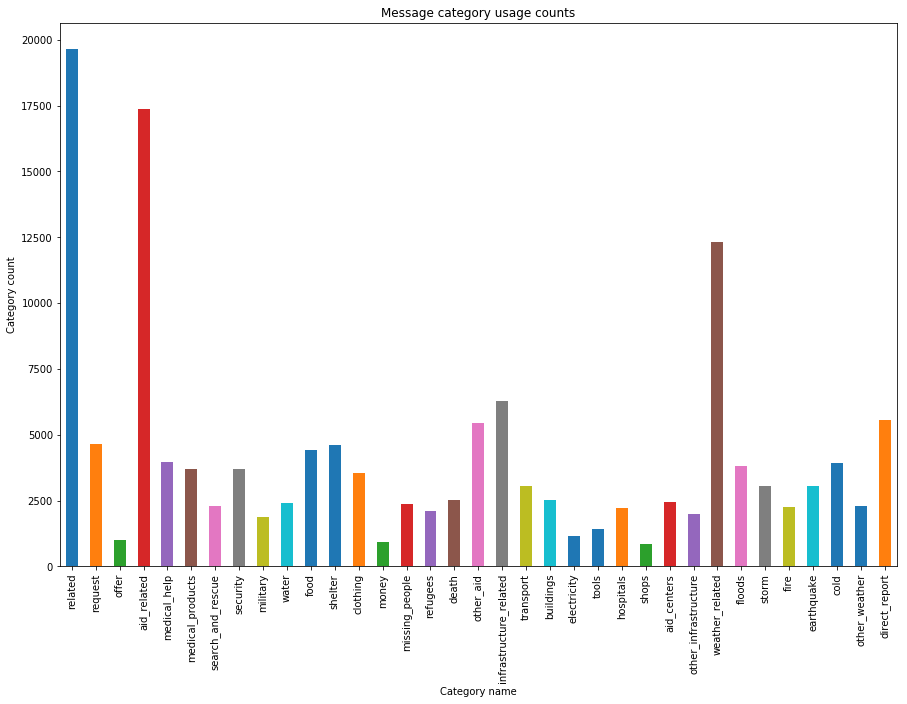

In [14]:
# Rebalance training data to better represent lowest occuring categories
def balance_training_data(training_features, training_targets):
    """"""
    
    # Get features & target names
    training_features = pd.Series.to_frame(training_features)
    feature_names = training_features.columns.values
    target_names = training_targets.columns.values
    # Get counts of training targets
    targets_totals = training_targets.sum(axis = 0)
    # Get mean of training targets
    mean_targets_totals = int(targets_totals.mean())
    # Merge features & targets
    training_df = training_features.join(training_targets)
    # Convert totals to df
    targets_totals = pd.Series.to_frame(targets_totals)
    # Get empty class rows
    empty_rows = training_df.loc[(training_df['related'] == 0)]
    # Get minority class rows 
    minority_rows = training_df.loc[(training_df['shops'] == 1) | (training_df['offer'] == 1) | (training_df['tools'] == 1) | (training_df['hospitals'] == 1) | (training_df['fire'] == 1) | (training_df['missing_people'] == 1) | (training_df['aid_centers'] == 1) | (training_df['clothing'] == 1) | (training_df['security'] == 1) | (training_df['cold'] == 1)]
    minority_rows_balanced = resample(minority_rows, n_samples=training_features.shape[0], random_state=0, replace=True)
    # Merge
    balanced_df = pd.concat([empty_rows, minority_rows_balanced], ignore_index=True)
    # Resplit features from targets
    training_features_balanced = balanced_df[feature_names]
    training_features_balanced = training_features_balanced.T.squeeze()
    training_targets_balanced = balanced_df[target_names]
    # Return balanced features & targets
    return training_features_balanced, training_targets_balanced

    
X_train_bal, y_train_bal = balance_training_data(X_train, y_train)
plot_target_feature_counts(y_train_bal)

We can see how the lowest occuring categories have improved a bit in proportion to the rest.

In [15]:
# Train pipeline with balanced data
pipeline2.fit(X_train_bal, y_train_bal)

# predict on test data
y_pred3 = pipeline2.predict(X_test)

# Re-structure returned numpy array as dataframe with same column names
y_pred3 = pd.DataFrame(y_pred2)
y_pred3.columns = target_names

# Evaluate the model
print(performance_report(y_test, y_pred3, target_names))

                        Accuracy  Precision    Recall        F1
related                 0.795392   0.801812  0.972428  0.878916
request                 0.903570   0.838946  0.523288  0.644544
offer                   0.992218   0.000000  0.000000  0.000000
aid_related             0.758773   0.804997  0.548077  0.652145
medical_help            0.928746   0.625767  0.200787  0.304024
medical_products        0.961245   0.704698  0.333333  0.452586
search_and_rescue       0.970095   0.387097  0.205714  0.268657
security                0.975435   0.080645  0.045872  0.058480
military                0.968874   0.571429  0.222222  0.320000
water                   0.963381   0.738636  0.637255  0.684211
food                    0.955294   0.800287  0.783404  0.791756
shelter                 0.947971   0.799499  0.550000  0.651685
clothing                0.987641   0.489130  0.569620  0.526316
money                   0.975282   0.409091  0.180000  0.250000
missing_people          0.985352   0.245

#### 8.3 Create new feature for starting verb with new model

In NLP people use a wide range of features to train text classifiers. Some use parts of speech features (such as nouns, verbs etc) as features. With this in mind we will add a new feature that detects any starting verbs.

https://www.nltk.org/book/ch06.html

https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

In [16]:
class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            if pos_tags:
                first_word, first_tag = pos_tags[0]
                #if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                #if first_tag in ['NN', 'NNS', 'NNP', 'NNPS']:
                #    return True
                return False
        return False

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

In [17]:
# Define new pipeline adding starting verb feature
pipeline3 = Pipeline([
    ('features', FeatureUnion([

        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ])),

        ('starting_verb', StartingVerbExtractor())
    ])),

    ('clf', MultiOutputClassifier(GradientBoostingClassifier(random_state=1)))
])

# Train pipeline
pipeline3.fit(X_train, y_train)

# predict on test data
y_pred4 = pipeline3.predict(X_test)

# Re-structure returned numpy array as dataframe with same column names
y_pred4 = pd.DataFrame(y_pred4)
y_pred4.columns = target_names

# Evaluate the model
print(performance_report(y_test, y_pred4, target_names))

                        Accuracy  Precision    Recall        F1
related                 0.794171   0.801650  0.970629  0.878084
request                 0.902807   0.832849  0.523288  0.642737
offer                   0.991913   0.000000  0.000000  0.000000
aid_related             0.758621   0.804891  0.547707  0.651849
medical_help            0.928441   0.615385  0.204724  0.307238
medical_products        0.961703   0.719178  0.333333  0.455531
search_and_rescue       0.970552   0.404255  0.217143  0.282528
security                0.977113   0.098039  0.045872  0.062500
military                0.969484   0.600000  0.222222  0.324324
water                   0.962313   0.722992  0.639706  0.678804
food                    0.954837   0.797704  0.781997  0.789773
shelter                 0.949039   0.807500  0.556897  0.659184
clothing                0.987183   0.473684  0.569620  0.517241
money                   0.974519   0.373134  0.166667  0.230415
missing_people          0.985047   0.215

#### 8.4 Combine new model, balanced data & verb feature

In [18]:
# Train pipeline
pipeline3.fit(X_train_bal, y_train_bal)

# predict on test data
y_pred5 = pipeline3.predict(X_test)

# Re-structure returned numpy array as dataframe with same column names
y_pred5 = pd.DataFrame(y_pred5)
y_pred5.columns = target_names

# Evaluate the model
print(performance_report(y_test, y_pred5, target_names))

                        Accuracy  Precision    Recall        F1
related                 0.791730   0.828876  0.916484  0.870481
request                 0.885871   0.811490  0.412785  0.547215
offer                   0.990388   0.024390  0.041667  0.030769
aid_related             0.554318   0.479624  0.944527  0.636194
medical_help            0.925694   0.554974  0.208661  0.303290
medical_products        0.957278   0.624113  0.279365  0.385965
search_and_rescue       0.974519   0.571429  0.182857  0.277056
security                0.972994   0.153061  0.137615  0.144928
military                0.969332   0.578947  0.254630  0.353698
water                   0.952548   0.587703  0.796569  0.676379
food                    0.949191   0.781250  0.738397  0.759219
shelter                 0.945377   0.765550  0.551724  0.641283
clothing                0.989777   0.568182  0.632911  0.598802
money                   0.972078   0.305882  0.173333  0.221277
missing_people          0.986268   0.266

### 9. Export your model as a pickle file

In [19]:
# save the model to disk
filename = 'final_model.sav'
#pickle.dump(pipeline2, open(filename, 'wb'))
joblib.dump(pipeline3, 'final_model.sav')

['final_model.sav']

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.